# **XAI-based Financial Fraud Detection**
# **by - Pratyush Dube**


# Model used - XGboost and Random Forest

Explainer (XAI) -

Global Instances - SHAP

Local Instances - LIME and SHAP

# Requirements

In [ ]:
#  """from google.colab import drive
#  drive.mount('/content/drive')"""

In [ ]:
!pip install lime
!pip install imbalanced-learn
!pip install lightgbm


In [ ]:
import pandas as pd
import numpy as np
import shap
from scipy import stats
import sklearn
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from lime.lime_tabular import LimeTabularExplainer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier


In [ ]:
df = pd.read_csv("credit_card_fraud.csv")

# EDA for this Dataset

In [ ]:
df

trans_date_trans_time                   merchant        category  \
0        2019-01-01 00:00:44  Heller, Gutmann and Zieme     grocery_pos   
1        2019-01-01 00:00:51             Lind-Buckridge   entertainment   
2        2019-01-01 00:07:27                  Kiehn Inc     grocery_pos   
3        2019-01-01 00:09:03                Beier-Hyatt    shopping_pos   
4        2019-01-01 00:21:32                 Bruen-Yost        misc_pos   
...                      ...                        ...             ...   
339602   2020-12-31 23:57:56             Schmidt-Larkin            home   
339603   2020-12-31 23:58:04  Pouros, Walker and Spence       kids_pets   
339604   2020-12-31 23:59:07            Reilly and Sons  health_fitness   
339605   2020-12-31 23:59:15                  Rau-Robel       kids_pets   
339606   2020-12-31 23:59:24            Breitenberg LLC          travel   

           amt                      city state      lat      long  city_pop  \
0       107.23                    Orient    WA  48.8878 -118.2105       149   
1       220.11                Malad City    ID  42.1808 -112.2620      4154   
2        96.29                   Grenada    CA  41.6125 -122.5258       589   
3         7.77  High Rolls Mountain Park    NM  32.9396 -105.8189       899   
4         6.85                   Freedom    WY  43.0172 -111.0292       471   
...        ...                       ...   ...      ...       ...       ...   
339602   12.68                     Wales    AK  64.7556 -165.6723       145   
339603   13.02                 Greenview    CA  41.5403 -122.9366       308   
339604   43.77                     Luray    MO  40.4931  -91.8912       519   
339605   86.88                   Burbank    WA  46.1966 -118.9017      3684   
339606    7.99                      Mesa    ID  44.6255 -116.4493       129   

                                      job         dob  \
0       Special educational needs teacher  1978-06-21   
1             Nature conservation officer  1962-01-19   
2                         Systems analyst  1945-12-21   
3                         Naval architect  1967-08-30   
4               Education officer, museum  1967-08-02   
...                                   ...         ...   
339602           Administrator, education  1939-11-09   
339603                Call centre manager  1958-09-20   
339604                       Town planner  1966-02-13   
339605                           Musician  1981-11-29   
339606                       Cartographer  1965-12-15   

                               trans_num  merch_lat  merch_long  is_fraud  
0       1f76529f8574734946361c461b024d99  49.159047 -118.186462         0  
1       a1a22d70485983eac12b5b88dad1cf95  43.150704 -112.154481         0  
2       413636e759663f264aae1819a4d4f231  41.657520 -122.230347         0  
3       8a6293af5ed278dea14448ded2685fea  32.863258 -106.520205         0  
4       f3c43d336e92a44fc2fb67058d5949e3  43.753735 -111.454923         0  
...                                  ...        ...         ...       ...  
339602  a8310343c189e4a5b6316050d2d6b014  65.623593 -165.186033         0  
339603  bd7071fd5c9510a5594ee196368ac80e  41.973127 -123.553032         0  
339604  9b1f753c79894c9f4b71f04581835ada  39.946837  -91.333331         0  
339605  6c5b7c8add471975aa0fec023b2e8408  46.658340 -119.715054         0  
339606  14392d723bb7737606b2700ac791b7aa  44.470525 -117.080888         0  

[339607 rows x 15 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339607 entries, 0 to 339606
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  339607 non-null  object 
 1   merchant               339607 non-null  object 
 2   category               339607 non-null  object 
 3   amt                    339607 non-null  float64
 4   city                   339607 non-null  object 
 5   state                  339607 non-null  object 
 6   lat                    339607 non-null  float64
 7   long                   339607 non-null  float64
 8   city_pop               339607 non-null  int64  
 9   job                    339607 non-null  object 
 10  dob                    339607 non-null  object 
 11  trans_num              339607 non-null  object 
 12  merch_lat              339607 non-null  float64
 13  merch_long             339607 non-null  float64
 14  is_fraud               339607 non-nu

# Categories of Transactions


In [ ]:
#Category wise bifurcation of data
value_counts = df['category'].value_counts()
value_counts

category
gas_transport     35089
grocery_pos       32732
home              32516
shopping_pos      30329
kids_pets         29704
shopping_net      26379
personal_care     24406
entertainment     24222
food_dining       23038
health_fitness    22593
misc_pos          20024
misc_net          16898
grocery_net       11355
travel            10322
Name: count, dtype: int64

<ipython-input-153-afcc993bed7f>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




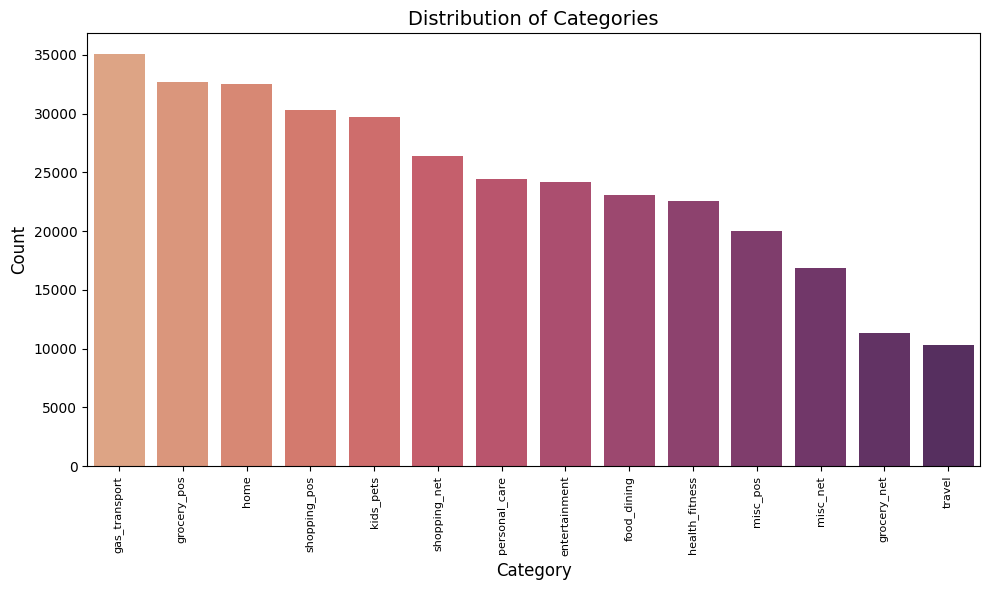

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=value_counts.index, y=value_counts.values, palette='flare')
plt.xticks(rotation=90)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Categories', fontsize=14)
plt.xticks(fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
value_counts = df['merchant'].value_counts()
value_counts

merchant
Kilback LLC        1149
Cormier LLC         985
Schumm PLC          931
Kuhn LLC            896
Dickinson Lt        891
                   ... 
Ebert-Daugherty     191
Johnston-Caspe      191
Kris-Kertzmann      186
Jerde-Hermann       184
Lynch-Moh           171
Name: count, Length: 693, dtype: int64

<ipython-input-155-45399d473f6c>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




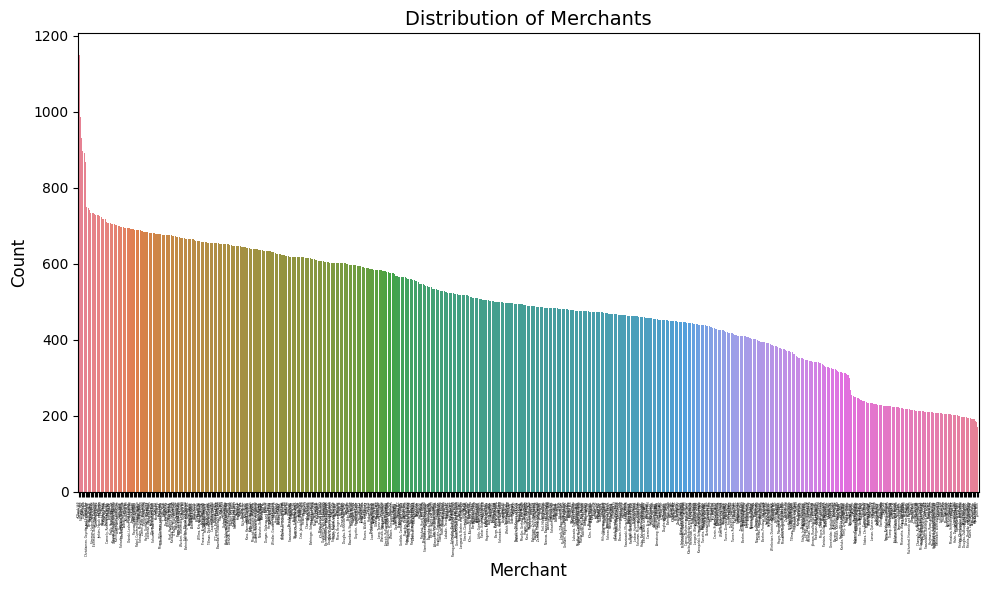

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=value_counts.index, y=value_counts.values, palette='husl')
plt.xticks(rotation=90)
plt.xlabel('Merchant', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Merchants', fontsize=14)
plt.xticks(fontsize=2)
plt.tight_layout()
plt.show()

In [ ]:
value_counts = df['city'].value_counts()
value_counts

city
Phoenix          7297
Fort Washakie    5116
Thompson         4386
Superior         4383
Conway           4381
                 ... 
Kirtland           10
Wappapello          8
Buellton            8
Pleasant Hill       8
Vacaville           7
Name: count, Length: 176, dtype: int64

<ipython-input-157-99f84e1cab52>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




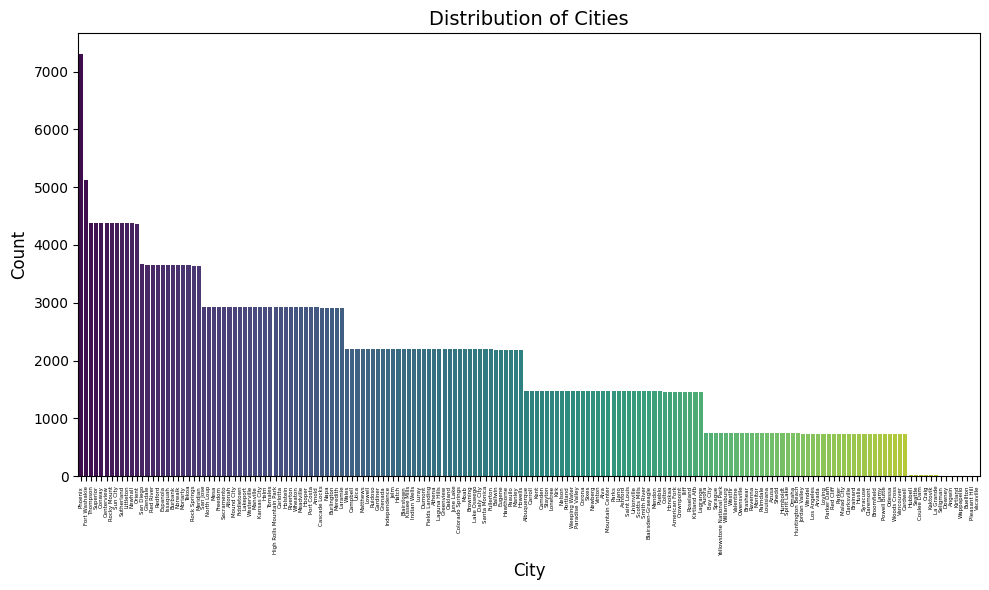

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('City', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Cities', fontsize=14)
plt.xticks(fontsize=4)
plt.tight_layout()  # Ensure that labels are not cut off
plt.show()

<ipython-input-158-83dfec6d0b8c>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




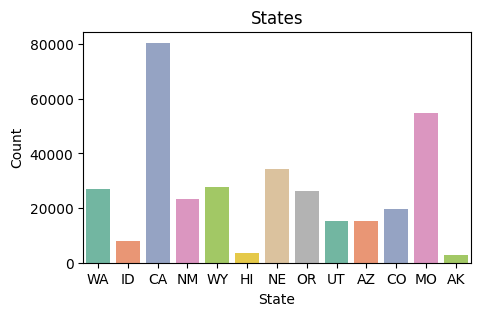

In [ ]:
plt.figure(figsize = (5, 3))
sns.countplot(x='state', data=df, palette='Set2')
plt.xlabel('State')
plt.ylabel('Count')
plt.title(f'States')
plt.show()

In [ ]:
value_counts = df['job'].value_counts()
value_counts

job
Surveyor, minerals              6589
Surveyor, land/geomatics        5855
Land/geomatics surveyor         5119
Insurance broker                5108
Systems analyst                 4398
                                ... 
Landscape architect                9
Systems developer                  9
Research scientist (medical)       8
Information officer                8
Clinical cytogeneticist            7
Name: count, Length: 163, dtype: int64

<ipython-input-160-31785b0a0dd9>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




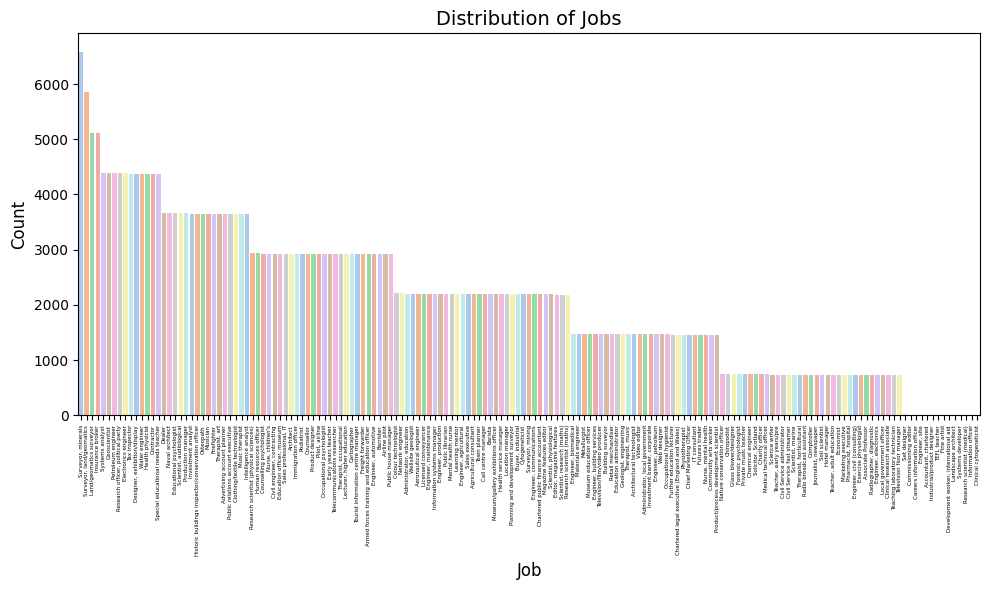

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=value_counts.index, y=value_counts.values, palette='pastel')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Job', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Jobs', fontsize=14)
plt.xticks(fontsize=4)
plt.tight_layout()  # Ensure that labels are not cut off
plt.show()

In [ ]:
df['is_fraud'].value_counts()

is_fraud
0    337825
1      1782
Name: count, dtype: int64

<ipython-input-162-b720c55445cf>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




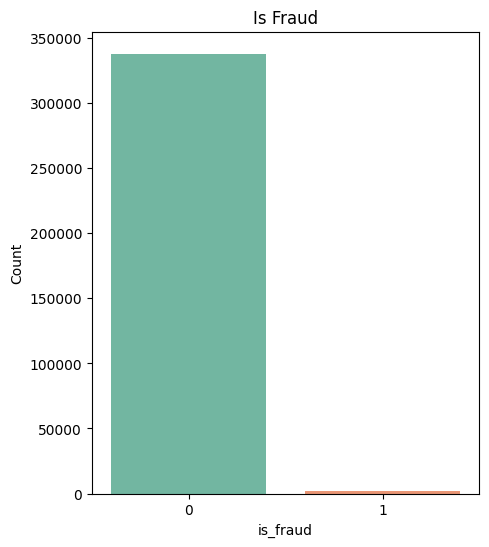

In [ ]:
plt.figure(figsize = (5, 6))
sns.countplot(x='is_fraud', data=df, palette='Set2')
plt.xlabel('is_fraud')
plt.ylabel('Count')
plt.title(f'Is Fraud')
plt.show()

### There are rarely any Fraud above, so there is a huge class imbalance

# 1. Converting Categorical variables

In [ ]:
# Assuming df is your DataFrame and 'categorical_column' is one of the categorical columns
label_encoder = LabelEncoder()

df['merchant_encoded'] = label_encoder.fit_transform(df['merchant'])
df['category_encoded'] = label_encoder.fit_transform(df['category'])
df['city_encoded'] = label_encoder.fit_transform(df['city'])
df['state_encoded'] = label_encoder.fit_transform(df['state'])
df['job_encoded'] = label_encoder.fit_transform(df['job'])
df['trans_num_encoded'] = label_encoder.fit_transform(df['trans_num'])

In [ ]:
df.columns

Index(['trans_date_trans_time', 'merchant', 'category', 'amt', 'city', 'state',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'merch_lat',
       'merch_long', 'is_fraud', 'merchant_encoded', 'category_encoded',
       'city_encoded', 'state_encoded', 'job_encoded', 'trans_num_encoded'],
      dtype='object')

# 2. Converting dob (date of birth)

In [ ]:
# Assuming df is your DataFrame and 'date_of_birth' is the date of birth column
df['dob'] = pd.to_datetime(df['dob'])

current_date = datetime.now()

df['age'] = (current_date - df['dob']).dt.days/365.25

# 3. Converting trans_date_trans_time

In [ ]:
# Assuming 'timestamp_column' is the name of your timestamp column
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

df['trans_date_trans_time_unix'] = df['trans_date_trans_time'].apply(lambda x: x.timestamp())

# 4. Dropping old columns

In [ ]:
df.drop(columns=['merchant','category','city','state','job','dob','trans_date_trans_time','trans_num'], axis = 1, inplace = True) \

#move column 'is_fraud' to the end
df = df[[col for col in df.columns if col != 'is_fraud'] + ['is_fraud']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339607 entries, 0 to 339606
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   amt                         339607 non-null  float64
 1   lat                         339607 non-null  float64
 2   long                        339607 non-null  float64
 3   city_pop                    339607 non-null  int64  
 4   merch_lat                   339607 non-null  float64
 5   merch_long                  339607 non-null  float64
 6   merchant_encoded            339607 non-null  int64  
 7   category_encoded            339607 non-null  int64  
 8   city_encoded                339607 non-null  int64  
 9   state_encoded               339607 non-null  int64  
 10  job_encoded                 339607 non-null  int64  
 11  trans_num_encoded           339607 non-null  int64  
 12  age                         339607 non-null  float64
 13  trans_date_tra

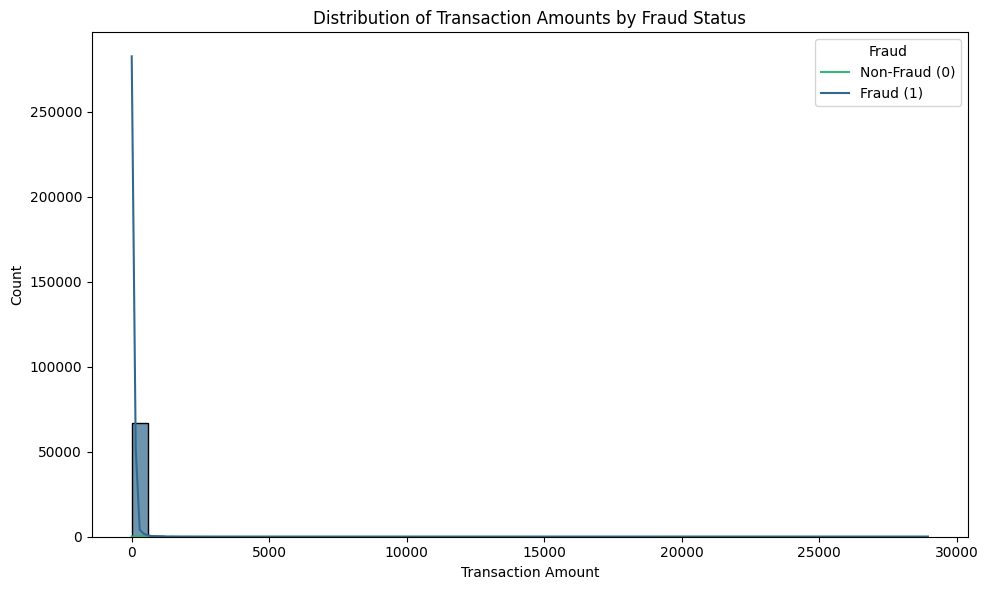

ValueError: Could not interpret value `Amount` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming X_test is a DataFrame that contains the "Amount" column
# and y_test contains the corresponding fraud labels (e.g., 0: non-fraud, 1: fraud).

# Combine the Amount column and fraud labels into one DataFrame
df_test = X_test.copy()
df_test['import matplotlib.pyplot as plt'] = y_test
import seaborn as sns
import pandas as pd

# Assuming X_test is a DataFrame that contains the "Amount" column
# and y_test contains the corresponding fraud labels (e.g., 0: non-fraud, 1: fraud).

# Combine the Amount column and fraud labels into one DataFrame
df_test = X_test.copy()
df_test['import matplotlib.pyplot as plt'] = y_test
import seaborn as sns
import pandas as pd

# Assuming X_test is a DataFrame that contains the "Amount" column
# and y_test contains the corresponding fraud labels (e.g., 0: non-fraud, 1: fraud).

# Combine the Amount column and fraud labels into one DataFrame
df_test = X_test.copy()
df_test['is_fraud'] = y_test

# Create a distribution plot using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=df_test, x='amt', hue='is_fraud', bins=50, kde=True, palette='viridis', alpha=0.7)

plt.title('Distribution of Transaction Amounts by Fraud Status')
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.legend(title='Fraud', labels=['Non-Fraud (0)', 'Fraud (1)'])
plt.tight_layout()
plt.show()


# Create a distribution plot using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=df_test, x='Amount', hue='Fraud', bins=50, kde=True, palette='viridis', alpha=0.7)

plt.title('Distribution of Transaction Amounts by Fraud Status')
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.legend(title='Fraud', labels=['Non-Fraud (0)', 'Fraud (1)'])
plt.tight_layout()
plt.show()


# Create a distribution plot using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=df_test, x='Amount', hue='Fraud', bins=50, kde=True, palette='viridis', alpha=0.7)

plt.title('Distribution of Transaction Amounts by Fraud Status')
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.legend(title='Fraud', labels=['Non-Fraud (0)', 'Fraud (1)'])
plt.tight_layout()
plt.show()


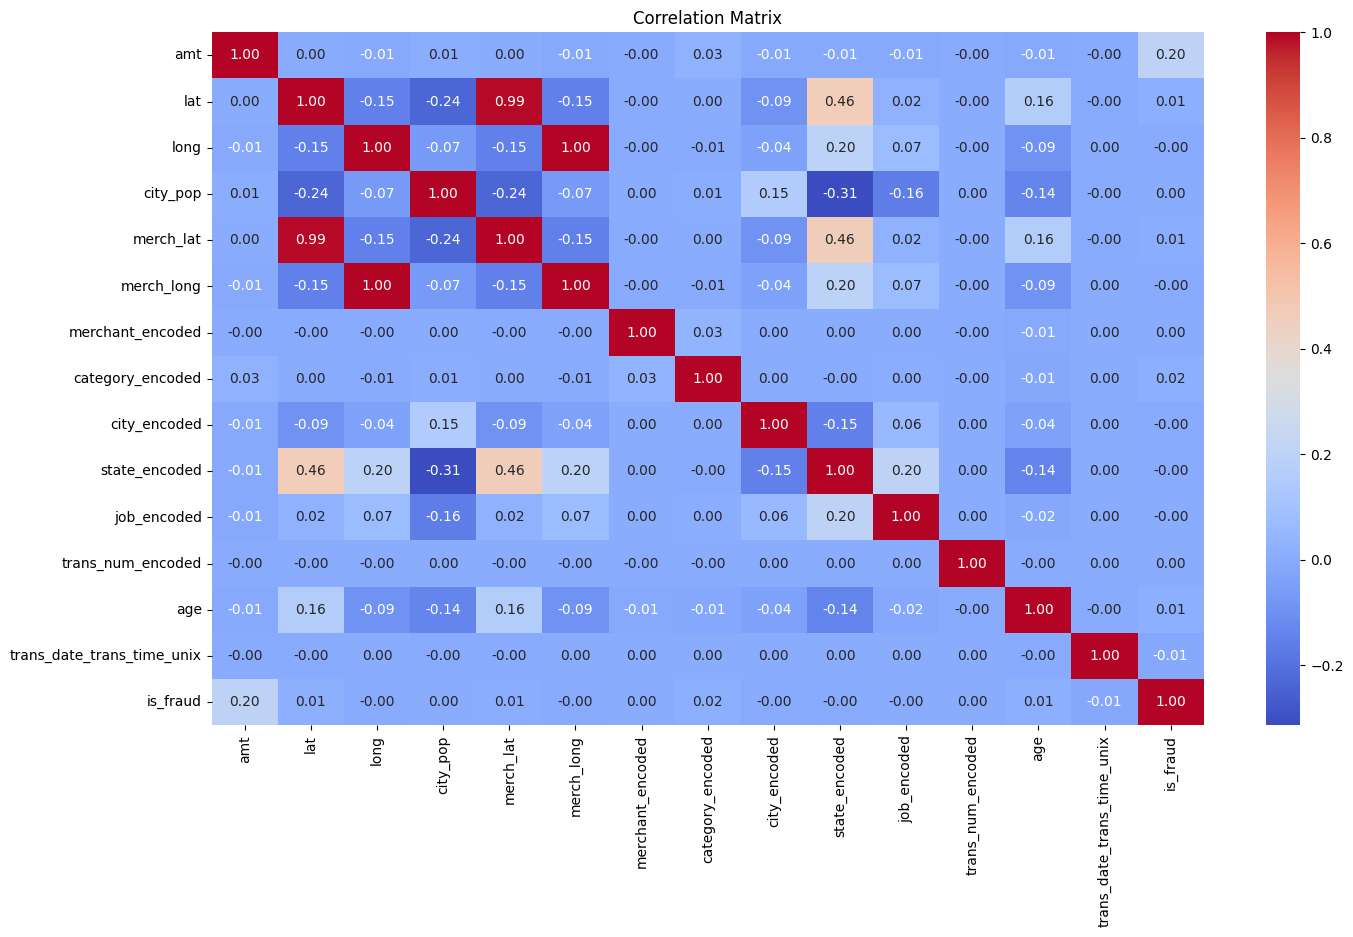

In [ ]:
# Assuming you have a DataFrame named 'df' with columns V1 to V28 and 'Class'
correlation_matrix = df.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(16, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# XGBoost Classifier

In [ ]:
features = ['amt', 'lat', 'long', 'merch_lat', 'merch_long', 'category_encoded', 'city_encoded', 'state_encoded', 'age', 'trans_date_trans_time_unix']
target = 'is_fraud'

In [ ]:

X = df[features]
y = df['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

**Handling Imbalanced Data (Using Class weight adjustment and SMOTE)**

1. Class Weight Adjustment

In [ ]:
# sum(negative instances) / sum(positive instances)
fraud_cases = df[df['is_fraud'] == 1]
non_fraud_cases = df[df['is_fraud'] == 0]

xgb_scale_pos_weight = len(non_fraud_cases.index) / len(fraud_cases.index)
xgb_scale_pos_weight

189.57631874298542

In [ ]:
model_XGB = xgboost.XGBClassifier(n_estimators = 100, max_depth = 2, subsample = 0.7, eta = 0.25,
                                  scale_pos_weight = xgb_scale_pos_weight, max_delta_step = 1)

In [ ]:
model_XGB = model_XGB.fit(X_train, y_train)

In [ ]:
y_pred = model_XGB.predict(X_test)

In [ ]:
#y_pred

In [ ]:
# Calculate the accuracy of the model

accuracy = accuracy_score(y_test, y_pred)

precision = precision_score(y_test, y_pred)

recall = recall_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)

roc_auc = roc_auc_score(y_test, y_pred)

scale_weight_scores = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC-AUC': roc_auc
}

print("Performance Metric of Class weight adjustmend based XGboost:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

Performance Metric of Class weight adjustmend based XGboost:
Accuracy: 0.9514
Precision: 0.0947
Recall: 0.9346
F1-score: 0.1720
AUC-ROC: 0.9430


2. SMOTE

In [ ]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [ ]:
model_smote = xgboost.XGBClassifier(
    n_estimators=100,
    max_depth=2,
    subsample=0.7,
    eta=0.25,
    max_delta_step=1,
    use_label_encoder=False,
    eval_metric='logloss'
)

model_smote.fit(X_train_smote, y_train_smote)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[16:23:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.25, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=1, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_pred_smote = model_smote.predict(X_test)

accuracy_s = accuracy_score(y_test, y_pred_smote)

precision_s = precision_score(y_test, y_pred_smote)

recall_s = recall_score(y_test, y_pred_smote)

f1_s = f1_score(y_test, y_pred_smote)

roc_auc_s = roc_auc_score(y_test, y_pred_smote)

smote_scores = {
    'Accuracy': accuracy_s,
    'Precision': precision_s,
    'Recall': recall_s,
    'F1 Score': f1_s,
    'ROC-AUC': roc_auc_s
 }

print("Performance Metrics for SMOTE based XGboost:")
print(f"Accuracy: {accuracy_s:.4f}")
print(f"Precision: {precision_s:.4f}")
print(f"Recall: {recall_s:.4f}")
print(f"F1-score: {f1_s:.4f}")
print(f"AUC-ROC: {roc_auc_s:.4f}")


Performance Metrics for SMOTE based XGboost:
Accuracy: 0.9620
Precision: 0.1104
Recall: 0.8556
F1-score: 0.1956
AUC-ROC: 0.9091


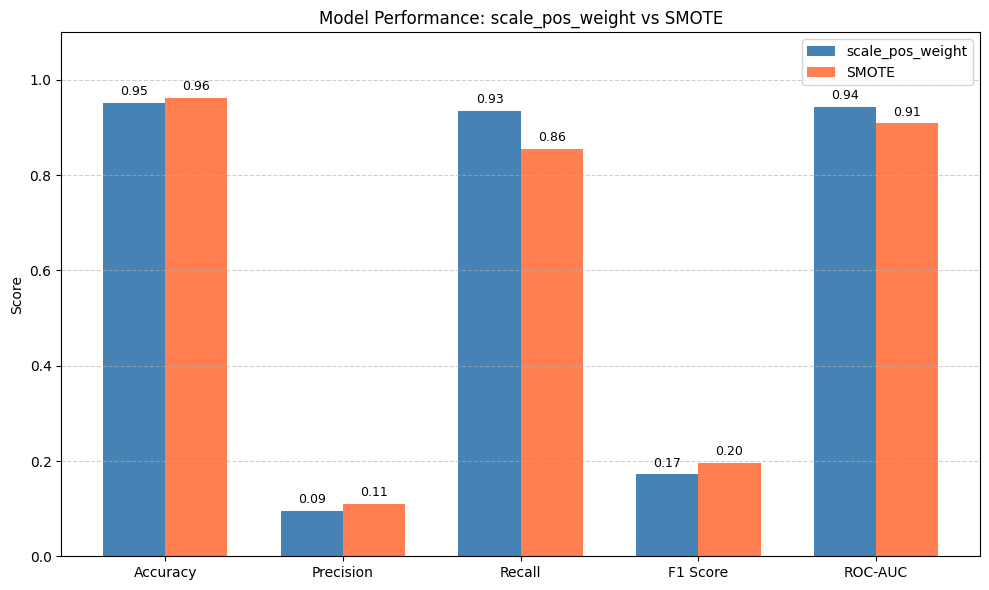

In [ ]:
#COMPARISON OF POS_SCALED vs SMOTE

metrics = list(scale_weight_scores.keys())
x = np.arange(len(metrics))  # metric index
width = 0.35  # width of bars

# Values
scale_weight_vals = list(scale_weight_scores.values())
smote_vals = list(smote_scores.values())

# Plotting
plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width/2, scale_weight_vals, width, label='scale_pos_weight', color='steelblue')
bars2 = plt.bar(x + width/2, smote_vals, width, label='SMOTE', color='coral')

# Labels
plt.ylabel('Score')
plt.title('Model Performance: scale_pos_weight vs SMOTE')
plt.xticks(x, metrics)
plt.ylim(0, 1.1)
plt.legend()

# Add bar labels
for bar in bars1 + bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=9)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Class based Adjustment is better because it maximizes recall, which is needed for our project as we don't want false negatives (fraud classified as not_fraud)




------



# Random Forest

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100,random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred_rf = rf_model.predict(X_test)

rf_scores = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1 Score': f1_score(y_test, y_pred_rf),
    'ROC-AUC': roc_auc_score(y_test, y_pred_rf)
}

print("Random Forest Performance Metrics:")
for metric, value in rf_scores.items():
    print(f"{metric}: {value:.4f}")


Random Forest Performance Metrics:
Accuracy: 0.9975
Precision: 0.9057
Recall: 0.6022
F1 Score: 0.7234
ROC-AUC: 0.8009


# Comparison of XGBoost vs Random Forest

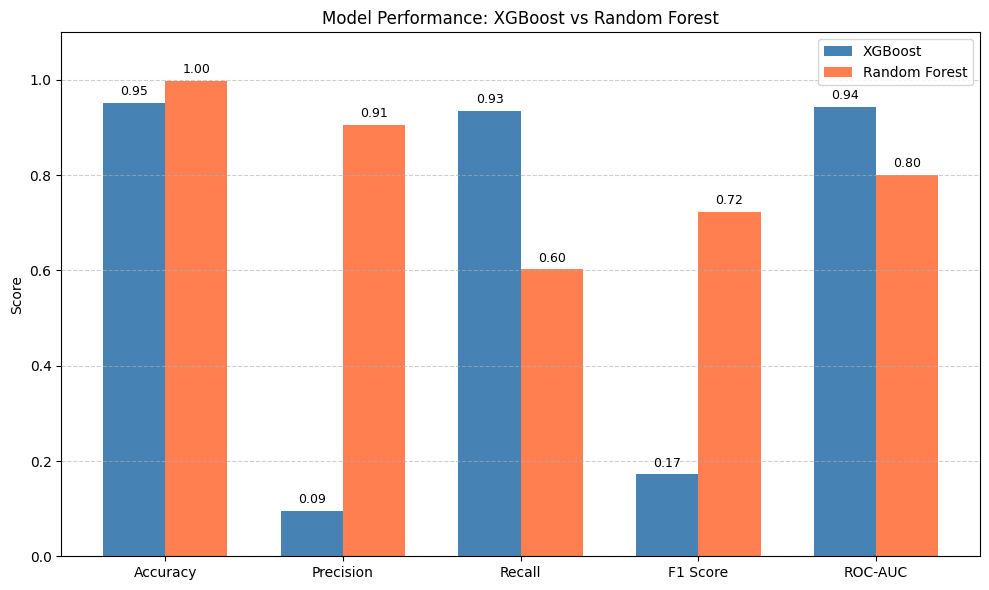

In [ ]:

metrics = list(scale_weight_scores.keys())
x = np.arange(len(metrics))  # metric index
width = 0.35  # width of bars

# Values
scale_weight_vals = list(scale_weight_scores.values())
rf_scores_vals = list(rf_scores.values())

# Plotting
plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width/2, scale_weight_vals, width, label='XGBoost', color='steelblue')
bars2 = plt.bar(x + width/2, rf_scores_vals, width, label='Random Forest', color='coral')

# Labels
plt.ylabel('Score')
plt.title('Model Performance: XGBoost vs Random Forest')
plt.xticks(x, metrics)
plt.ylim(0, 1.1)
plt.legend()

# Add bar labels
for bar in bars1 + bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=9)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#LightGBM

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

# 1. Instantiate model
lgbm_model = LGBMClassifier(
    objective='binary',
    num_leaves=31,
    learning_rate=0.05,
    n_estimators=100
)

# 2. Fit model (no early stopping)
lgbm_model.fit(X_train, y_train)

# 3. Predictions
y_pred_lgbm = lgbm_model.predict(X_test)
y_pred_prob_lgbm = lgbm_model.predict_proba(X_test)[:, 1]  # Probability for class=1

# 4. Compute performance metrics
#    - For ROC-AUC, we typically use predicted probabilities rather than labels
lgbm_scores = {
    'Accuracy': accuracy_score(y_test, y_pred_lgbm),
    'Precision': precision_score(y_test, y_pred_lgbm),
    'Recall': recall_score(y_test, y_pred_lgbm),
    'F1 Score': f1_score(y_test, y_pred_lgbm),
    'ROC-AUC': roc_auc_score(y_test, y_pred_prob_lgbm)
}

# 5. Print the results
print("=== LightGBM Performance Metrics ===")
for metric_name, metric_val in lgbm_scores.items():
    print(f"{metric_name}: {metric_val:.4f}")


[LightGBM] [Info] Number of positive: 1415, number of negative: 270270
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1771
[LightGBM] [Info] Number of data points in the train set: 271685, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005208 -> initscore=-5.252292
[LightGBM] [Info] Start training from score -5.252292
=== LightGBM Performance Metrics ===
Accuracy: 0.9971
Precision: 0.8496
Recall: 0.5695
F1 Score: 0.6819
ROC-AUC: 0.9931


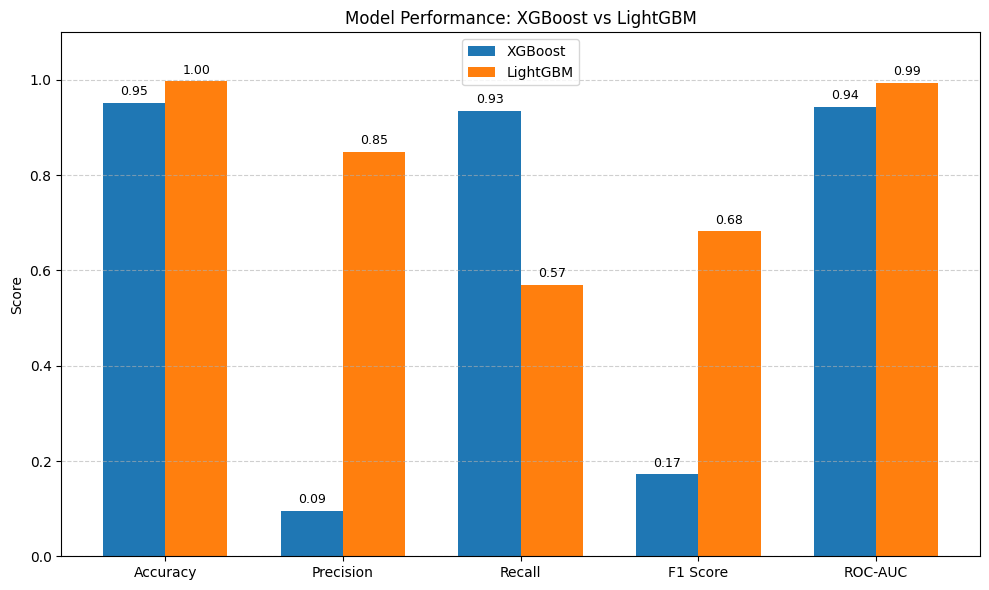

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example dictionaries of metrics
# xgb_scores = {
#     'Accuracy': 0.95,
#     'Precision': 0.93,
#     'Recall': 0.90,
#     'F1': 0.91
# }
# lgbm_scores = {
#     'Accuracy': 0.96,
#     'Precision': 0.94,
#     'Recall': 0.92,
#     'F1': 0.93
# }

# 1. Extract metrics and values
metrics = list(scale_weight_scores.keys())
xgb_vals = list(scale_weight_scores.values())
lgbm_vals = list(lgbm_scores.values())

# 2. Set up the figure
x = np.arange(len(metrics))
width = 0.35  # width of the bars

plt.figure(figsize=(10, 6))

# 3. Plot bars
bars1 = plt.bar(x - width/2, xgb_vals, width, label='XGBoost')
bars2 = plt.bar(x + width/2, lgbm_vals, width, label='LightGBM')

# 4. Labeling and layout
plt.ylabel('Score')
plt.title('Model Performance: XGBoost vs LightGBM')
plt.xticks(x, metrics)
plt.ylim(0, 1.1)
plt.legend()

# 5. Add bar labels
for bar in bars1 + bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0,
             height + 0.01,
             f'{height:.2f}',
             ha='center',
             va='bottom',
             fontsize=9)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# **GLOBAL XAI**

# Global SHAP

In [ ]:
explainer = shap.Explainer(model_XGB, X_train)

In [ ]:
shap_values = explainer.shap_values(X_test)

 99%|===================| 67080/67922 [00:46<00:00]       

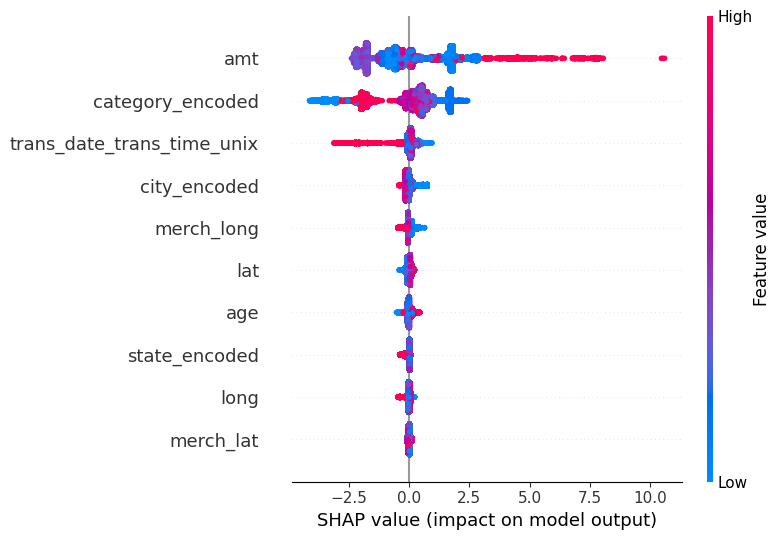

In [ ]:
shap.summary_plot(shap_values, X_test, feature_names=features)

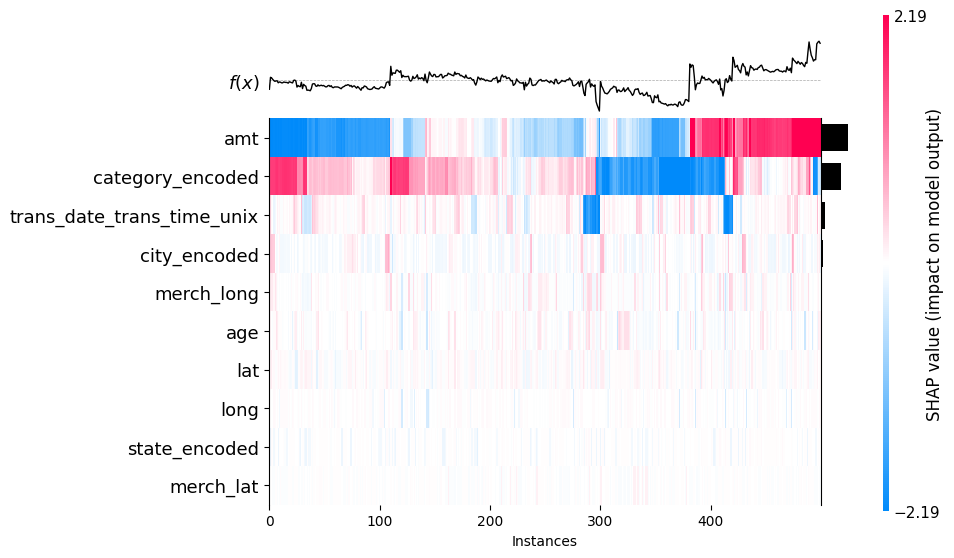

<Axes: xlabel='Instances'>

In [ ]:
shap_values = explainer(X_test.iloc[:500])
shap.plots.heatmap(shap_values)

# **LOCAL XAI**

# Local SHAP

In [ ]:
!jupyter nbextension enable --py widgetsnbextension --sys-prefix


Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json


In [ ]:
from google.colab import output
output.enable_custom_widget_manager()



In [ ]:
import shap
shap.initjs()

import plotly.offline as py
py.init_notebook_mode(connected=True)



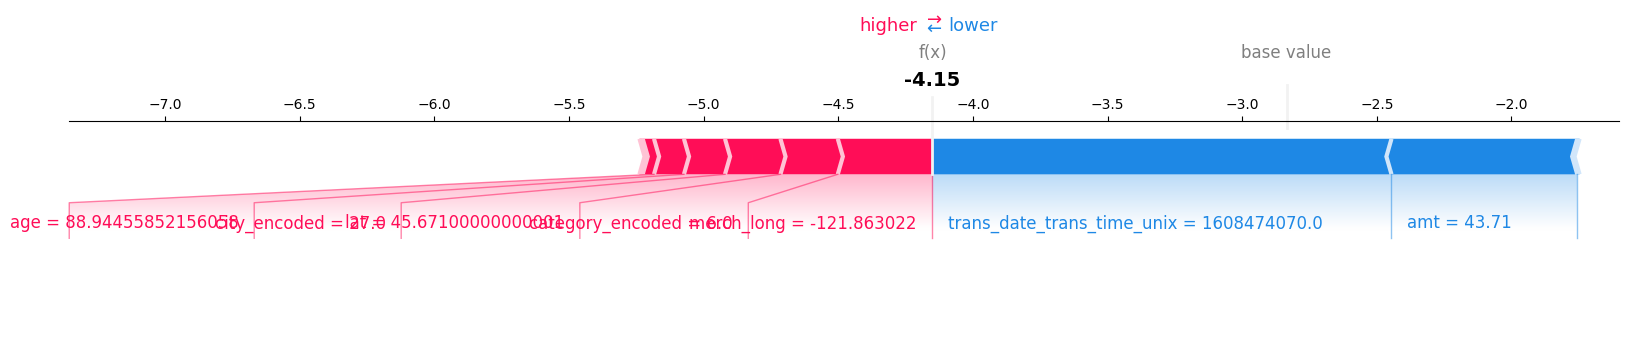

In [ ]:

import shap
shap.initjs()

instance_idx = 8
shap_values = explainer(X_test.iloc[instance_idx])

shap.force_plot(
    explainer.expected_value,
    shap_values.values,
    X_test.iloc[instance_idx],
    matplotlib=True
)


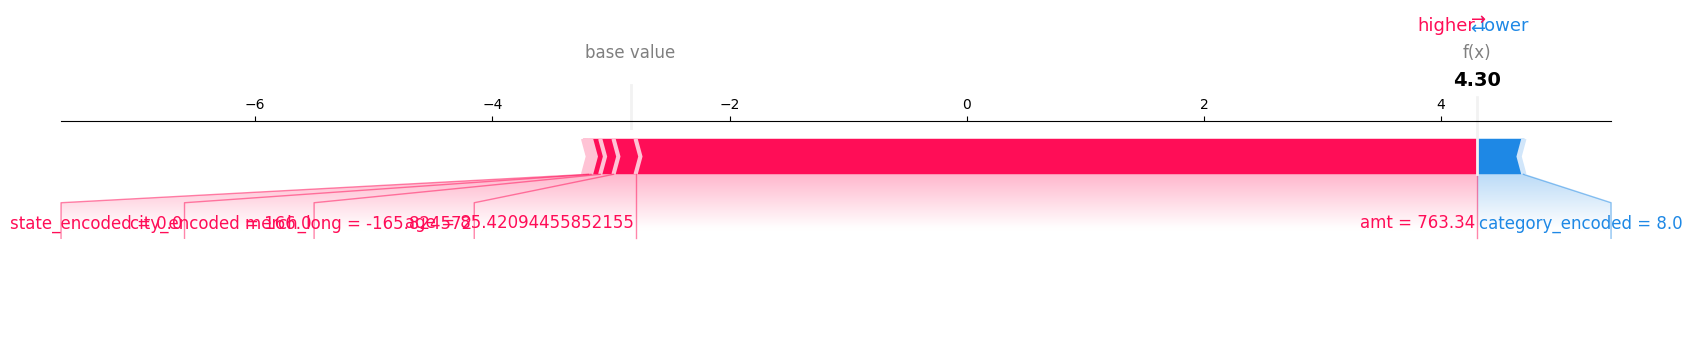

In [ ]:
import shap
shap.initjs()

instance_idx = 11

# Explain the model's predictions for instance_idx (given instance by me)
shap_values = explainer(X_test.iloc[instance_idx])

shap.force_plot(explainer.expected_value,
                shap_values.values,
                X_test.iloc[instance_idx],
                matplotlib=True
                )

# LIME

In [ ]:
lime_explainer = LimeTabularExplainer(X_train.values, mode="classification", feature_names=features, class_names=['is_not_fraud','is_fraud'])

In [ ]:
instance_idx = 8

# Explain the prediction
explanation = lime_explainer.explain_instance(X_test.values[instance_idx], model_XGB.predict_proba, num_features=len(X_test.columns))

# Visualize the explanation
explanation.show_in_notebook()

In [ ]:
instance_idx = 11

# Explain the prediction
explanation = lime_explainer.explain_instance(X_test.values[instance_idx], model_XGB.predict_proba, num_features=len(X_test.columns))

# Visualize the explanation
explanation.show_in_notebook()